## [Computational Social Science] Project 5: Natural Language Processing

In this project, you will use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, you will do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

You will explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

In [2]:
# pandas and numpy

import pandas as pd
import numpy as np

# punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()

import nltk #to add words to stop words
import re
import string

# textblob
from textblob import TextBlob

# model preparation
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

# countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# gensim
import gensim
from gensim import models

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#set seed
import random
random.seed(10)

#word clouds
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#topic modeling
from sklearn.decomposition import LatentDirichletAllocation

In [3]:
#import file 
congress_tweets = pd.read_csv("data/116th Congressional Tweets and Demographics.csv")
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
0,1.081010e+18,RepByrne,2019-01-03T21:23:00-05:00,Great news for Baldwin County! The economy of ...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
1,1.080880e+18,RepByrne,2019-01-03T12:30:38-05:00,Outstanding news today from @Airbus! @JetBlue ...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
2,1.080830e+18,RepByrne,2019-01-03T09:12:07-05:00,RT @senatemajldr Democrats will have to get se...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
3,1.080890e+18,RepByrne,2019-01-03T13:20:53-05:00,Here is a sign of things to come: As Democrats...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
4,1.080870e+18,RepByrne,2019-01-03T12:10:26-05:00,Let's understand what we're dealing with here:...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"


In [4]:
#check the size of the dataset
print("Shape of current df:", congress_tweets.shape)

Shape of current df: (946791, 16)


In [5]:
#subset the data
## fill in this line of code with a sufficient number of tweets, depending on your computational resources
congress_tweets = congress_tweets.sample(frac=0.01, random_state=0)
print("Shape of current df:", congress_tweets.shape)
congress_tweets.head()

Shape of current df: (9468, 16)


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
637157,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437"
148554,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958"
373598,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869"
811015,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843"
582485,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431"


In [6]:
#reset index
congress_tweets = congress_tweets.dropna(subset = ['text']).reset_index(drop = True)  #remove missing values
print("Shape of current df:", congress_tweets.shape)
congress_tweets.head()

Shape of current df: (9468, 16)


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437"
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958"
2,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869"
3,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843"
4,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431"


In [7]:
#text data
congress_tweets['text'].head(15)

0     All of #OH14 salutes you, Patrolman St. Clair!...
1     In Case You Missed It: Bipartisanship works – ...
2     Wishing a happy #Passover to all those celebra...
3     RT @WhiteHouse President @realDonaldTrump just...
4     I just sent a letter demanding the Administrat...
5     The President’s attacks on Rep. @Ilhan are dis...
6     RT @HouseGOP It's time to get serious about ho...
7     RT @wdtnews With five confirmed COVID-19 cases...
8     RT @SVLeadershipGrp "We can only be game chang...
9     “This nation will remain the land of the free ...
10    This is true and we will address this soon.......
11    Preach. 🙏🏾 https://twitter.com/shondarhimes/st...
12    Among public institutions, @ASU is third in th...
13    There is no way Eric Swalwell should continue ...
14    NOW: on the air with @SethLeibsohn to talk abo...
Name: text, dtype: object

## Preprocessing

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL 

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

In [8]:
#replace all independents as democrats 
congress_tweets['party']=congress_tweets['party'].replace(r"Independent", "Democrat", regex=True)

In [9]:
#Remove emojis
def rem_emoji(text):
    emoji_pattern = re.compile("["
                            u"\U0001F600-\U0001F64F"  # emoticons
                            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                            u"\U0001F680-\U0001F6FF"  # transport & map symbols
                            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            u"\U00002500-\U00002BEF"  # chinese char
                            u"\U00002702-\U000027B0"
                            u"\U00002702-\U000027B0"
                            u"\U000024C2-\U0001F251"
                            u"\U0001f926-\U0001f937"
                            u"\U00010000-\U0010ffff"
                            u"\u2640-\u2642" 
                            u"\u2600-\u2B55"
                            u"\u200d"
                            u"\u23cf"
                            u"\u23e9"
                            u"\u231a"
                            u"\ufe0f"  # dingbats
                            u"\u3030"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

#passing the emoji function to 'text'
congress_tweets['text'] = congress_tweets['text'].apply(rem_emoji)

In [10]:
#Remove line breaks 
def rem_lbreaks(text):
    line_breaks = re.compile('\n')
    return line_breaks.sub(r'', text)

#Passing function to 'text'
congress_tweets['text'] = congress_tweets['text'].apply(rem_lbreaks)

In [11]:
#Remove urls
def rem_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

#Passing the function to 'text' 
congress_tweets['text'] = congress_tweets['text'].apply(rem_urls)

In [12]:
#create rem_punc_stop() function
def rem_punc_stop(text):
    stop_words = STOP_WORDS
    nlp.Defaults.stop_words.add("rt") 
    nlp.Defaults.stop_words.add("qt") 
    nlp.Defaults.stop_words.add("amp") 
    nlp.Defaults.stop_words.add("need") #NE: to get rid of the word "need" big on all wordclouds 
    nlp.Defaults.stop_words.add("today") #NE: to get rid of the word "today" big on all wordclouds  
    nlp.Defaults.stop_words.add("thank")
    
    punc = set(punctuation)
    punc.update(['–','“',"‘",'¯','1⃣']) # add additional symbols
    
    punc_free = "".join([ch for ch in text if ch not in punc])
    
    doc = nlp(punc_free)
    
    #create tokens
    spacy_words = [token.text.lower() for token in doc] #to make the text all lower case 

    
    no_punc = [word for word in spacy_words if word not in stop_words]
    
    return no_punc


In [13]:
congress_tweets = congress_tweets.dropna(subset = ['text']).reset_index(drop = True)  #remove missing values

In [14]:
# apply rem_punc_stop function to every row of our dataframe
congress_tweets['tokens'] = congress_tweets['text'].map(lambda x: rem_punc_stop(x)) # x = each item in the 'text'
print("Shape of current df:", congress_tweets.shape)
congress_tweets.head()

Shape of current df: (9468, 17)


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[oh14, salutes, patrolman, st, clair, , fox8..."
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[case, missed, bipartisanship, works, , bill,..."
2,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869","[wishing, happy, passover, celebrating, seder,..."
3,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[whitehouse, president, realdonaldtrump, signe..."
4,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[sent, letter, demanding, administration, stop..."


In [15]:
#Remove blank spaces
def rem_spaces(text):
    text = [item.strip(' ') for item in text]  #removes white spaces in each item
    return [item for item in text if item]  #removes items that are empty strings

#Passing function to 'tokens'
congress_tweets['tokens'] = congress_tweets['tokens'].apply(rem_spaces)
print("Shape of current df:", congress_tweets.shape)
congress_tweets.head()

Shape of current df: (9468, 17)


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[oh14, salutes, patrolman, st, clair, fox8news..."
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[case, missed, bipartisanship, works, bill, er..."
2,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869","[wishing, happy, passover, celebrating, seder,..."
3,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[whitehouse, president, realdonaldtrump, signe..."
4,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[sent, letter, demanding, administration, stop..."


In [16]:
#Remove tweets with no words 
congress_tweets = congress_tweets[congress_tweets['tokens'].map(lambda x: len(x) > 0)].reset_index(drop = True)
print("Shape of current df:", congress_tweets.shape)
congress_tweets.head()

Shape of current df: (9432, 17)


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[oh14, salutes, patrolman, st, clair, fox8news..."
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[case, missed, bipartisanship, works, bill, er..."
2,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869","[wishing, happy, passover, celebrating, seder,..."
3,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[whitehouse, president, realdonaldtrump, signe..."
4,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[sent, letter, demanding, administration, stop..."


In [17]:
congress_tweets['tokens'][0] # text string -> tokens in list form -- no spaces, emojis, urls, or other punctuation

['oh14',
 'salutes',
 'patrolman',
 'st',
 'clair',
 'fox8news',
 '5yearold',
 'battling',
 'cancer',
 'bainbridge',
 'police',
 'officer',
 'day',
 'rooseveltlfox8']

In [18]:
#get rid of tokens that are bracket
congress_tweets['length_tokens']=congress_tweets['tokens'].str.len()
# congress_tweets=pd.DataFrame(congress_tweets[congress_tweets['length_tokens']>2])
print("Shape of current df:", congress_tweets.shape)

#EG: as we can see below, we're not getting rid of tokens that are brackets, we're just getting rid of tweets
# that are short (ie, 1 or 2 words). Is that what we want? If so, let's uncomment line above and delete this
# comment and line below. Otherwise, let's delete this whole cell and the two cells below.
congress_tweets.loc[congress_tweets['length_tokens'] < 3]

Shape of current df: (9432, 18)


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,length_tokens
406,1.334210e+18,RepDebHaaland,2020-12-02T13:59:10-05:00,"@repbenraylujan Thank you, @repbenraylujan!",Deb Haaland,Rep,3-Jan-19,12/2/1960,F,NM,1,Democrat,"319,667","385,234","415,335","335,788","[repbenraylujan, repbenraylujan]",2
435,1.147910e+18,GerryConnolly,2019-07-07T12:58:20-04:00,Congratulations to the @USWNT!,Gerry Connolly,Rep,3-Jan-09,3/30/1950,M,VA,11,Democrat,"1,769,443","1,981,473","1,971,820","1,822,522","[congratulations, uswnt]",2
500,1.245880e+18,RepPeteOlson,2020-04-02T21:22:26-04:00,@OutsideMid You wish.,Pete Olson,Rep,3-Jan-09,12/9/1962,M,TX,22,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[outsidemid, wish]",2
594,1.091460e+18,WarrenDavidson,2019-02-01T17:30:48-05:00,But Russia... #DeedsNotWords,Warren Davidson,Rep,7-Jun-16,3/1/1970,M,OH,8,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[russia, deedsnotwords]",2
824,1.311680e+18,SenatorRounds,2020-10-01T10:32:17-04:00,Learn more about our legislation here:,Mike Rounds,Sen,3-Jan-15,10/24/1954,M,SD,Senate,Republican,"227,721","117,458","145,039","210,610","[learn, legislation]",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9295,1.267930e+18,RepEspaillat,2020-06-02T17:33:37-04:00,#StopPoliceBrutality #BlackLivesMatter,Adriano Espaillat,Rep,3-Jan-17,9/27/1954,M,NY,13,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[stoppolicebrutality, blacklivesmatter]",2
9334,1.154520e+18,SenWhitehouse,2019-07-25T18:31:56-04:00,See reports: 1⃣,Sheldon Whitehouse,Sen,3-Jan-07,10/20/1955,M,RI,Senate,Democrat,"180,543","252,525","279,677","157,204","[reports, 1⃣]",2
9354,1.235690e+18,RepDeSaulnier,2020-03-05T17:13:40-05:00,RSVP:,Mark DeSaulnier,Rep,3-Jan-15,3/31/1952,M,CA,11,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958",[rsvp],1
9366,1.289220e+18,RepWilson,2020-07-31T11:05:10-04:00,This is bad.,Frederica Wilson,Rep,3-Jan-11,11/5/1942,F,FL,24,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447",[bad],1


In [19]:
congress_tweets[congress_tweets['tokens'].map(lambda d: len(d)) > 0].shape

(9432, 18)

In [20]:
#Length of smallest tweet
congress_tweets['tokens'].str.len().min()

1

## Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered word frequencies, word clouds, word/character counts, scattertext, and topic modeling as possible exploration tools. 

## EDA 1. WordClouds

In [21]:
# initialize wordcloud data and function

# Convert list of tokens back to text string
text = ' '.join(congress_tweets['tokens'].map(lambda text: ' '.join(text))) #join every item with space

# feed string to wordcloud
wordcloud = WordCloud().generate(text) #wordcloud library

In [22]:
# create a dictionary of word frequencies

text_dictionary = wordcloud.process_text(text)
# sort the dictionary
word_freq={k: v for k, v in sorted(text_dictionary.items(),reverse=True, key=lambda item: item[1])}

#use words_ to print relative word frequencies
rel_freq=wordcloud.words_

#print results
print(list(word_freq.items())[:5])
print(list(rel_freq.items())[:5])

[('american', 619), ('work', 555), ('new', 548), ('help', 526), ('time', 525)]
[('american', 1.0), ('work', 0.8966074313408724), ('new', 0.8852988691437803), ('help', 0.8497576736672051), ('time', 0.8481421647819063)]


In [23]:
# EG: it looks like "today", "american", "need", "work", "day", "week", "year", "help", and "support" are (will be?) useless

#MJK/NE
Based on the highest word frequencies we inspected the word clouds and determined that we should not remove these words because they are prevalent for some parties and positions but not others. 

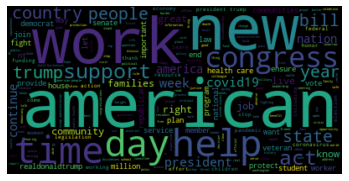

In [24]:
# plot WordCloud(ALL)

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [25]:
#Table - political party-Republicans

congress_tweets_R = congress_tweets[(congress_tweets['party']=='Republican')]
print("Shape of current df:", congress_tweets_R.shape)
congress_tweets_R.head()

Shape of current df: (3409, 18)


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,length_tokens
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[oh14, salutes, patrolman, st, clair, fox8news...",14
3,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[whitehouse, president, realdonaldtrump, signe...",12
6,1.311670e+18,RepMcCaul,2020-10-01T10:21:28-04:00,RT @HouseGOP It's time to get serious about ho...,Michael McCaul,Rep,3-Jan-05,1/14/1962,M,TX,10,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[housegop, time, holding, china, accountable, ...",23
7,1.244250e+18,RepStefanik,2020-03-29T08:48:34-04:00,RT @wdtnews With five confirmed COVID-19 cases...,Elise Stefanik,Rep,3-Jan-15,7/2/1984,F,NY,21,Republican,"2,819,533","4,556,118","4,485,741","2,490,431","[wdtnews, confirmed, covid19, cases, jefferson...",20
13,1.340700e+18,GOPLeader,2020-12-20T11:50:36-05:00,There is no way Eric Swalwell should continue ...,Kevin McCarthy,Rep,3-Jan-07,1/26/1965,M,CA,23,Republican,"4,483,814","8,753,792","7,854,285","4,839,958","[way, eric, swalwell, continue, serve, house, ...",8


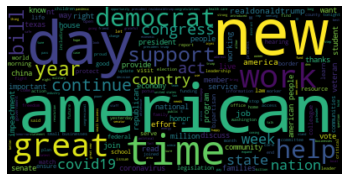

In [26]:
#WordCloud for Republicans

# Convert list of tokens back to text string
text_R = ' '.join(congress_tweets_R['tokens'].map(lambda text: ' '.join(text))) #join every item with space

# feed string to wordcloud
wordcloud = WordCloud().generate(text_R) #wordcloud library

# plot!
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [27]:
#Table - political party-Democrats

congress_tweets_D = congress_tweets[(congress_tweets['party']=='Democrat')]
print("Shape of current df:", congress_tweets_D.shape)
congress_tweets_D.head()

Shape of current df: (6023, 18)


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,length_tokens
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[case, missed, bipartisanship, works, bill, er...",9
2,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869","[wishing, happy, passover, celebrating, seder,...",6
4,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[sent, letter, demanding, administration, stop...",22
5,1.117090e+18,RepWexton,2019-04-13T11:42:15-04:00,The President’s attacks on Rep. @Ilhan are dis...,Jennifer Wexton,Rep,3-Jan-19,5/27/1968,F,VA,10,Democrat,"1,769,443","1,981,473","1,971,820","1,822,522","[president, attacks, rep, ilhan, dishonest, da...",19
8,1.157440e+18,RepSwalwell,2019-08-02T19:47:23-04:00,"RT @SVLeadershipGrp ""We can only be game chang...",Eric Swalwell,Rep,3-Jan-13,11/16/1980,M,CA,15,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[svleadershipgrp, game, changers, accept, resp...",18


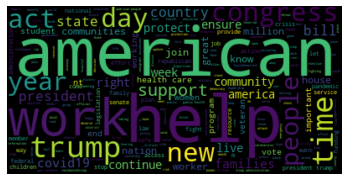

In [28]:
##WordCloud for Democrats
# Convert list of tokens back to text string
text_D = ' '.join(congress_tweets_D['tokens'].map(lambda text: ' '.join(text))) #join every item with space

# feed string to wordcloud
wordcloud = WordCloud().generate(text_D) #wordcloud library

# plot!
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [29]:
#Table - Legislator position-Senator

congress_tweets_sen = congress_tweets[congress_tweets["position"]=="Sen"]
print("Shape of current df:", congress_tweets_sen.shape)
congress_tweets_sen.head()

Shape of current df: (2239, 18)


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,length_tokens
12,1.105870e+18,SenatorSinema,2019-03-13T12:36:37-04:00,"Among public institutions, @ASU is third in th...",Kyrsten Sinema,Sen,3-Jan-19,7/12/1976,F,AZ,Senate,Democrat,"1,252,401","1,161,167","1,025,232","1,233,654","[public, institutions, asu, nation, student, f...",12
24,1.249040e+18,SenatorSinema,2020-04-11T14:19:58-04:00,"Arizonans: if you've lost your job, been furlo...",Kyrsten Sinema,Sen,3-Jan-19,7/12/1976,F,AZ,Senate,Democrat,"1,252,401","1,161,167","1,025,232","1,233,654","[arizonans, ve, lost, job, furloughed, hours, ...",20
28,1.105590e+18,MartinHeinrich,2019-03-12T18:15:17-04:00,Proud that my bipartisan bill with @SenAlexand...,Martin Heinrich,Sen,3-Jan-13,10/17/1971,M,NM,Senate,Democrat,"319,667","385,234","415,335","335,788","[proud, bipartisan, bill, senalexander, signed...",22
34,1.105460e+18,PattyMurray,2019-03-12T09:12:00-04:00,ICYMI: The latest #TrumpBudget has massive tax...,Patty Murray,Sen,3-Jan-17,10/11/1950,F,WA,Senate,Democrat,"1,221,747","1,742,718","1,755,396","1,290,670","[icymi, latest, trumpbudget, massive, tax, bre...",22
35,1.186770e+18,McConnellPress,2019-10-22T18:12:22-04:00,RT @ARCgov ARC Federal Co-Chairman Tim Thomas:...,Mitch McConnell,Sen,3-Jan-15,2/20/1942,M,KY,Senate,Republican,"1,202,971","628,854","679,370","1,087,190","[arcgov, arc, federal, cochairman, tim, thomas...",22


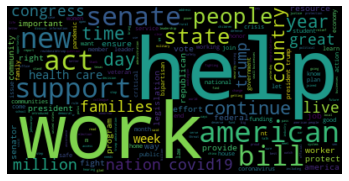

In [30]:
##WordCloud for Senators
# Convert list of tokens back to text string
text_sen = ' '.join(congress_tweets_sen['tokens'].map(lambda text: ' '.join(text))) #join every item with space

# feed string to wordcloud
wordcloud = WordCloud().generate(text_sen) #wordcloud library

# plot!
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [31]:
#Table - Legislator position- House of Representatives 

congress_tweets_hrep = congress_tweets[congress_tweets["position"]=="Rep"]
print("Shape of current df:", congress_tweets_hrep.shape)
congress_tweets_hrep.head()

Shape of current df: (7193, 18)


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,length_tokens
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[oh14, salutes, patrolman, st, clair, fox8news...",14
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[case, missed, bipartisanship, works, bill, er...",9
2,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869","[wishing, happy, passover, celebrating, seder,...",6
3,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[whitehouse, president, realdonaldtrump, signe...",12
4,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[sent, letter, demanding, administration, stop...",22


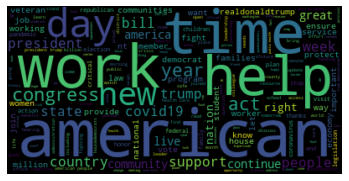

In [32]:
##WordCloud for House of Representatives
# Convert list of tokens back to text string
text_hrep = ' '.join(congress_tweets_hrep['tokens'].map(lambda text: ' '.join(text))) #join every item with space

# feed string to wordcloud
wordcloud = WordCloud().generate(text_hrep) #wordcloud library

# plot!
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

## MJK - FIX TEXT THURSDAY

## Wordcloud shows that the most frequently used words do not vary a lot by party(e.g., today, thank, american). However, it shows that the republicans use "great" and "new" more frequently, while democrats use "healthcare" and "communities" more frequently- which is expected.

## Wordcloud also shows that both Senates and Representatives use "today" and "need" a lot. But Senates use "work" more often while Representatives use "thank" more often.

## EDA 2. Topic modeling 

In [33]:
#TASK 3: GENERAL MODEL (1), REDO TOPIC MODELING PER PARTY (2), PER POSITION (2)
# add column where tokens are concatenated into a single string
congress_tweets['tokens_str'] = congress_tweets['tokens'].str.join(" ")
congress_tweets

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,length_tokens,tokens_str
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[oh14, salutes, patrolman, st, clair, fox8news...",14,oh14 salutes patrolman st clair fox8news 5year...
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[case, missed, bipartisanship, works, bill, er...",9,case missed bipartisanship works bill eradicat...
2,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869","[wishing, happy, passover, celebrating, seder,...",6,wishing happy passover celebrating seder tonight
3,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[whitehouse, president, realdonaldtrump, signe...",12,whitehouse president realdonaldtrump signed bi...
4,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[sent, letter, demanding, administration, stop...",22,sent letter demanding administration stop play...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9427,1.093180e+18,RepFrenchHill,2019-02-06T11:28:17-05:00,Our greatest strength lies within our love for...,French Hill,Rep,3-Jan-15,12/5/1956,M,AR,2,Republican,"684,872","380,494","394,409","647,744","[greatest, strength, lies, love, repdebdingell...",30,greatest strength lies love repdebdingell john...
9428,1.305250e+18,RepGregoryMeeks,2020-09-13T17:07:09-04:00,"RT @davidaxelrod What a leader would say:Yes, ...",Gregory Meeks,Rep,3-Feb-98,9/25/1953,M,NY,5,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[davidaxelrod, leader, sayyes, face, deadly, p...",22,davidaxelrod leader sayyes face deadly pandemi...
9429,1.296180e+18,SenHydeSmith,2020-08-19T16:28:15-04:00,RT @tatereeves The Chicago mayor says Mississi...,Cindy Hyde-Smith,Sen,9-Apr-18,5/10/1959,F,MS,Senate,Republican,"700,714","485,131","562,949","710,746","[tatereeves, chicago, mayor, says, mississippi...",44,tatereeves chicago mayor says mississippians b...
9430,1.191400e+18,RepJahanaHayes,2019-11-04T11:42:37-05:00,Tomorrow is #ElectionDay. Make sure to get out...,Jahana Hayes,Rep,3-Jan-19,3/8/1973,F,CT,5,Democrat,"673,215","897,572","905,083","634,892","[tomorrow, electionday, sure, voice, heard]",5,tomorrow electionday sure voice heard


In [34]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [35]:
# create new variables to loop LDA

congress_tweets['tweets_R'] = '' 
congress_tweets.loc[congress_tweets['party']=='Republican', 'tweets_R'] = congress_tweets['tokens_str']

congress_tweets['tweets_D'] = ''
congress_tweets.loc[congress_tweets['party']=='Democrat', 'tweets_D'] = congress_tweets['tokens_str']

congress_tweets['tweets_Sen'] = ''
congress_tweets.loc[congress_tweets['position']=='Sen', 'tweets_Sen'] = congress_tweets['tokens_str']

congress_tweets['tweets_HRep'] = '' 
congress_tweets.loc[congress_tweets['position']=='Rep', 'tweets_HRep'] = congress_tweets['tokens_str']

congress_tweets.tail(10)  # check new variables 

#EG: you created the new columns and assigned a blank space ' '. I replaced it with an empty string '' to make 
# sure the white spaces don't come back to haunt us in the future.

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,...,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,length_tokens,tokens_str,tweets_R,tweets_D,tweets_Sen,tweets_HRep
9422,1.119350e+18,RepRickLarsen,2019-04-19T17:24:58-04:00,Visited @Castle_Cooke to hear abt how it suppo...,Rick Larsen,Rep,3-Jan-01,6/15/1965,M,WA,...,"1,742,718","1,755,396","1,290,670","[visited, castlecooke, hear, abt, supports, ge...",26,visited castlecooke hear abt supports general ...,,visited castlecooke hear abt supports general ...,,visited castlecooke hear abt supports general ...
9423,1.278700e+18,RepAndyBiggsAZ,2020-07-02T10:44:14-04:00,"@realDonaldTrump As our economy is restored, i...",Andy Biggs,Rep,3-Jan-17,11/7/1958,M,AZ,...,"1,161,167","1,025,232","1,233,654","[realdonaldtrump, economy, restored, imperativ...",11,realdonaldtrump economy restored imperative pr...,realdonaldtrump economy restored imperative pr...,,,realdonaldtrump economy restored imperative pr...
9424,1.250090e+18,RepEliotEngel,2020-04-14T11:50:55-04:00,"RT @HouseForeign ""In March '19, Trump cut off ...",Eliot Engel,Rep,3-Jan-89,2/18/1947,M,NY,...,"4,556,118","4,485,741","2,490,431","[houseforeign, march, 19, trump, cut, aidi, el...",44,houseforeign march 19 trump cut aidi el salvad...,,houseforeign march 19 trump cut aidi el salvad...,,houseforeign march 19 trump cut aidi el salvad...
9425,1.137100e+18,RepDanKildee,2019-06-07T17:00:00-04:00,Got the chance to check out @MottCollege’s new...,Dan Kildee,Rep,3-Jan-13,8/11/1958,M,MI,...,"2,268,839","2,564,569","2,115,256","[got, chance, check, mottcollege, new, culinar...",23,got chance check mottcollege new culinary arts...,,got chance check mottcollege new culinary arts...,,got chance check mottcollege new culinary arts...
9426,1.284560e+18,BradSherman,2020-07-18T14:58:10-04:00,From when I joined Congress &amp; began workin...,Brad Sherman,Rep,3-Jan-97,10/24/1954,M,CA,...,"8,753,792","7,854,285","4,839,958","[joined, congress, began, working, joining, ce...",23,joined congress began working joining celebrat...,,joined congress began working joining celebrat...,,joined congress began working joining celebrat...
9427,1.093180e+18,RepFrenchHill,2019-02-06T11:28:17-05:00,Our greatest strength lies within our love for...,French Hill,Rep,3-Jan-15,12/5/1956,M,AR,...,"380,494","394,409","647,744","[greatest, strength, lies, love, repdebdingell...",30,greatest strength lies love repdebdingell john...,greatest strength lies love repdebdingell john...,,,greatest strength lies love repdebdingell john...
9428,1.305250e+18,RepGregoryMeeks,2020-09-13T17:07:09-04:00,"RT @davidaxelrod What a leader would say:Yes, ...",Gregory Meeks,Rep,3-Feb-98,9/25/1953,M,NY,...,"4,556,118","4,485,741","2,490,431","[davidaxelrod, leader, sayyes, face, deadly, p...",22,davidaxelrod leader sayyes face deadly pandemi...,,davidaxelrod leader sayyes face deadly pandemi...,,davidaxelrod leader sayyes face deadly pandemi...
9429,1.296180e+18,SenHydeSmith,2020-08-19T16:28:15-04:00,RT @tatereeves The Chicago mayor says Mississi...,Cindy Hyde-Smith,Sen,9-Apr-18,5/10/1959,F,MS,...,"485,131","562,949","710,746","[tatereeves, chicago, mayor, says, mississippi...",44,tatereeves chicago mayor says mississippians b...,tatereeves chicago mayor says mississippians b...,,tatereeves chicago mayor says mississippians b...,
9430,1.191400e+18,RepJahanaHayes,2019-11-04T11:42:37-05:00,Tomorrow is #ElectionDay. Make sure to get out...,Jahana Hayes,Rep,3-Jan-19,3/8/1973,F,CT,...,"897,572","905,083","634,892","[tomorrow, electionday, sure, voice, heard]",5,tomorrow electionday sure voice heard,,tomorrow electionday sure voice heard,,tomorrow electionday sure voice heard
9431,1.250810e+18,GOPLeader,2020-04-16T11:32:26-04:00,We are navigating one of the toughest challeng...,Kevin McCarthy,Rep,3-Jan-07,1/26/1965,M,CA,...,"8,753,792","7,854,285","4,839,958","[navigating, toughest, challenges, century, qu...",1

In [36]:
# loop through each of the five variables containing tweets and create five topic models for each

new_vars = ["tokens_str", "tweets_R", "tweets_D", "tweets_Sen", "tweets_HRep"]
titles = ["All", "Republican", "Democrat", "Senate", "House of Rep"]
topics= [] # initialize empty list to add topic dfs to 

for var,n in zip(new_vars,titles): 
    X = congress_tweets[var]
    tf = TfidfVectorizer() #creating an object : tf model
    tfidf_matrix =  tf.fit_transform(X) #downweigh the common words & upweigh the rare words
    dense_matrix = tfidf_matrix.todense() #remove all the columns where there are 0
    lda = LatentDirichletAllocation(n_components=5, max_iter=20, random_state=0) #initialize model/ prespecify the parameter n => "5 topics",  #random_state for reproducibility
    lda = lda.fit(dense_matrix) # pass through our dense matrix
    tf_feature_names = tf.get_feature_names()
    print("The topics for", n, "are: ")
    print_top_words(lda, tf_feature_names, 20) #prints out top words using different objects attached to our lda model
    topic_dist = lda.transform(tfidf_matrix) #get the topic distribution array
    topic_dist_df = pd.DataFrame(topic_dist).reset_index(drop = True)
    #df_w_topics = topic_dist_df.join(congress_tweets.reset_index(drop = True)) #merge back with original dataframe, drop missing and reset index
    topics.append(topic_dist_df)

/Users/ernesto/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/Users/ernesto/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


The topics for All are: 

Topic #0:
de la en el para newsletter los que del por weekly al su con happy las accepting blacklivesmatter un una

Topic #1:
enrollment getcovered mothers tips granite library ventilators treasury coverage tennessee covidreliefirs hatred enroll dougducey misinformation resolve invited hsbcgop holocaust sencorygardner

Topic #2:
health people act trump help covid19 work president congress house american americans bill new support time care families country day

Topic #3:
impeachment happy realdonaldtrump president birthday tune trump wishing schiff witnesses friend protectourcare democrats pm house evidence watch updates live family

Topic #4:
happy join wishing martin lowerdrugcosts cases housecommerce netneutrality usrepkcastor drug flight negotiate emissions prices king luther lakes robocalls panel savethenet



/Users/ernesto/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/Users/ernesto/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


The topics for Republican are: 

Topic #0:
realdonaldtrump border great week new house watch america american time president covid19 vote tune act work support congress live school

Topic #1:
american work house bill coronavirus time great people congress act new economy jobs realdonaldtrump day discuss watch good small americans

Topic #2:
president support health realdonaldtrump help people americans house democrats great american congress continue country day act honor care covid19 impeachment

Topic #3:
democrats covid19 great help new support act coronavirus jobs work country realdonaldtrump president americans bill tax congress going news american

Topic #4:
day happy president great realdonaldtrump nation latest covid19 senate american democrats families people help continue congress like read morning new



/Users/ernesto/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/Users/ernesto/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


The topics for Democrat are: 

Topic #0:
trump health act people president help house americans care covid19 families congress work bill american time support new workers senate

Topic #1:
de happy great day pfas la new year district school celebrate justiceinpolicing state para en country work welcome nation john

Topic #2:
women years black reflect thehill honor history world iran proud thanks great de congratulations america epidemic disinformation barackobama views la

Topic #3:
hall join town pm office questions live community school rsvp covid19 new facebook county congress honor great update register tomorrow

Topic #4:
happy wishing birthday congratulations world celebrating thanks sacrificed competition antisemitism art happynewyear de west excited hate uniform gold league wind



/Users/ernesto/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/Users/ernesto/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


The topics for Senate are: 

Topic #0:
great senate read trump help federal time people covid19 health bill day like president coronavirus new work americans community congress

Topic #1:
care help health new people senate support american act covid19 country federal relief president learn work families trump women crisis

Topic #2:
people trump administration new coronavirus senate military day national president work great protect year lives america state realdonaldtrump fight justice

Topic #3:
trump families act workers work president week senate national support covid19 continue help working pandemic people jobs congress care country

Topic #4:
health act bill trump senate congress help care americans public support president work people state new american house ensure protections



/Users/ernesto/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/Users/ernesto/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


The topics for House of Rep are: 

Topic #0:
de happy newsletter la app en birthday podcast para el steam foxnews por joy required weekly repjohnlewis channel tonight los

Topic #1:
rent congratulations hbcus de guidelines cases owe usa chemicals ksleg ks02 la deaths mortgage cancel rental muellerreport fl07 welcome cumulative

Topic #2:
hr8 de dosomething la el angeles launch repthompson happythanksgiving sondland los honest en virginians sisters obstruct momsdemand disappointing ivankatrump mcbob128

Topic #3:
house president people trump health covid19 act congress help time work american americans new support day great bill country families

Topic #4:
wishing lied buildthewall happy wearamask 19th de christmas governortomwolf la johncornyn easter sentedcruz 300000 limited uswnt campaigns cohen corner merry



In [37]:
topics_df = pd.concat([topics[0],
                    topics[1],
                    topics[2], 
                    topics[3],
                    topics[4]], axis=1)

topics_df.head()

,0,1,2,3,4,0,1,2,3,4,...,0,1,2,3,4,0,1,2,3,4
0,0.042951,0.042963,0.133530,0.043158,0.737399,0.042678,0.044033,0.042939,0.827467,0.042884,...,0.2,0.2,0.2,0.2,0.2,0.042916,0.042954,0.672886,0.198126,0.043118
1,0.051107,0.051160,0.536885,0.308702,0.052145,0.200000,0.200000,0.200000,0.200000,0.200000,...,0.2,0.2,0.2,0.2,0.2,0.050906,0.050905,0.050927,0.796320,0.050942
2,0.449667,0.059771,0.060322,0.369810,0.060431,0.200000,0.200000,0.200000,0.200000,0.200000,...,0.2,0.2,0.2,0.2,0.2,0.760192,0.059213,0.059522,0.060950,0.060123
3,0.047165,0.046194,0.590126,0.270319,0.046196,0.046665,0.046280,0.046588,0.814219,0.046248,...,0.2,0.2,0.2,0.2,0.2,0.045958,0.045964,0.046040,0.627217,0.234821
4,0.036479,0.036498,0.854052,0.036485,0.036486,0.200000,0.200000,0.200000,0.200000,0.200000,...,0.2,0.2,0.2,0.2,0.2,0.036484,0.036413,0.036395,0.854313,0.036395


In [38]:
# df_w_topics

#EG: should this line be deleted? There's no variable df_w_topics, so this cell returns an error


## MJK All 10 topics do not seem to have a lot of separation between senators and representatives

#MJK/NE: visualizations don't make sense because the topics are different, how do we compare the without visualizations? WE WILL ASK KQ
 

In [39]:
# # Visualization- Topic 1 - for position
# sns.displot(df_w_topics, x=df_w_topics[0], hue = "position", kind = 'kde', fill = 'true')
# plt.show()

In [40]:
# # Visualization- Topic 1 - for party 
# sns.displot(df_w_topics, x=df_w_topics[0], hue = "party", kind = 'kde', fill = 'true')
# plt.show()

In [41]:
# # Visualization- Topic 5 - for position
# sns.displot(df_w_topics, x=df_w_topics[4], hue = "position", kind = 'kde', fill = 'true')
# plt.show()

In [42]:
# # Visualization- Topic 5 - for party 
# sns.displot(df_w_topics, x=df_w_topics[4], hue = "party", kind = 'kde', fill = 'true')
# plt.show()


## MJK:

## Sentiment Analysis

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

`TextBlob` has already been imported in the top cell.

## 1) Exploration: Overall

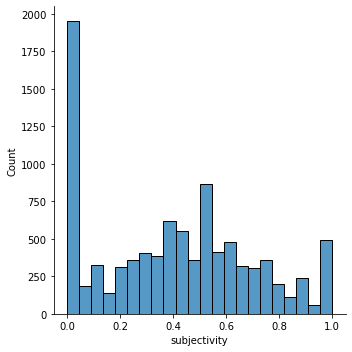

In [43]:
#check subjectivity for all tweets 
congress_tweets['subjectivity'] = congress_tweets['tokens_str'].map(lambda text: TextBlob(text).sentiment.subjectivity)
sns.displot(congress_tweets, x="subjectivity")
plt.show()

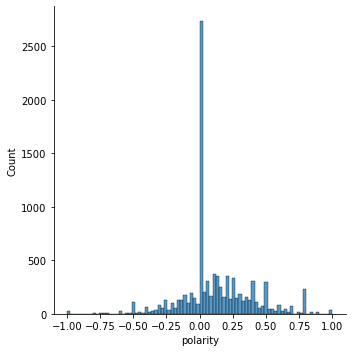

In [44]:
#check sentiment/polarity for all tweets 
congress_tweets['polarity'] = congress_tweets['tokens_str'].map(lambda text: TextBlob(text).sentiment.polarity)
sns.displot(congress_tweets, x="polarity")
plt.show()

In [45]:
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,...,romney_2012_state_share,tokens,length_tokens,tokens_str,tweets_R,tweets_D,tweets_Sen,tweets_HRep,subjectivity,polarity
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,...,"2,661,437","[oh14, salutes, patrolman, st, clair, fox8news...",14,oh14 salutes patrolman st clair fox8news 5year...,oh14 salutes patrolman st clair fox8news 5year...,,,oh14 salutes patrolman st clair fox8news 5year...,0.0,0.000000
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,...,"4,839,958","[case, missed, bipartisanship, works, bill, er...",9,case missed bipartisanship works bill eradicat...,,case missed bipartisanship works bill eradicat...,,case missed bipartisanship works bill eradicat...,0.0,0.000000
2,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,...,"971,869","[wishing, happy, passover, celebrating, seder,...",6,wishing happy passover celebrating seder tonight,,wishing happy passover celebrating seder tonight,,wishing happy passover celebrating seder tonight,1.0,0.800000
3,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,...,"4,569,843","[whitehouse, president, realdonaldtrump, signe...",12,whitehouse president realdonaldtrump signed bi...,whitehouse president realdonaldtrump signed bi...,,,whitehouse president realdonaldtrump signed bi...,0.0,0.000000
4,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,...,"2,490,431","[sent, letter, demanding, administration, stop...",22,sent letter demanding administration stop play...,,sent letter demanding administration stop play...,,sent letter demanding administration stop play...,1.0,-0.166667


##  NE FIX TOMORROW
## Subjective sentences generally refer to personal opinion, emotion or judgment whereas objective refers to factual information. Although the overall distribution is normal, more tweets were factual information(subjectivity ==0) compared to opinions(subjectivity ==1).

## 2) Choose two legislators, one liberal and one conservative

In [46]:
# get list of Republican tweets
congress_tweets_R.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,length_tokens
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[oh14, salutes, patrolman, st, clair, fox8news...",14
3,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[whitehouse, president, realdonaldtrump, signe...",12
6,1.311670e+18,RepMcCaul,2020-10-01T10:21:28-04:00,RT @HouseGOP It's time to get serious about ho...,Michael McCaul,Rep,3-Jan-05,1/14/1962,M,TX,10,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[housegop, time, holding, china, accountable, ...",23
7,1.244250e+18,RepStefanik,2020-03-29T08:48:34-04:00,RT @wdtnews With five confirmed COVID-19 cases...,Elise Stefanik,Rep,3-Jan-15,7/2/1984,F,NY,21,Republican,"2,819,533","4,556,118","4,485,741","2,490,431","[wdtnews, confirmed, covid19, cases, jefferson...",20
13,1.340700e+18,GOPLeader,2020-12-20T11:50:36-05:00,There is no way Eric Swalwell should continue ...,Kevin McCarthy,Rep,3-Jan-07,1/26/1965,M,CA,23,Republican,"4,483,814","8,753,792","7,854,285","4,839,958","[way, eric, swalwell, continue, serve, house, ...",8


In [47]:
# select David Joyce
congress_tweets_DavidJoyce = congress_tweets[congress_tweets["name_wikipedia"]=="David Joyce"].copy()
congress_tweets_DavidJoyce

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,...,romney_2012_state_share,tokens,length_tokens,tokens_str,tweets_R,tweets_D,tweets_Sen,tweets_HRep,subjectivity,polarity
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,...,"2,661,437","[oh14, salutes, patrolman, st, clair, fox8news...",14,oh14 salutes patrolman st clair fox8news 5year...,oh14 salutes patrolman st clair fox8news 5year...,,,oh14 salutes patrolman st clair fox8news 5year...,0.00000,0.000000
2006,1.166760e+18,RepDaveJoyce,2019-08-28T13:29:18-04:00,"As the son of a wounded WWII vet, I applaud @P...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,...,"2,661,437","[son, wounded, wwii, vet, applaud, potus, deci...",22,son wounded wwii vet applaud potus decision ca...,son wounded wwii vet applaud potus decision ca...,,,son wounded wwii vet applaud potus decision ca...,0.15000,-0.100000
3105,1.161730e+18,RepDaveJoyce,2019-08-14T15:49:18-04:00,Always honored to speak at the annual 3chamber...,David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,...,"2,661,437","[honored, speak, annual, 3chamber, luncheon, s...",29,honored speak annual 3chamber luncheon spoke 1...,honored speak annual 3chamber luncheon spoke 1...,,,honored speak annual 3chamber luncheon spoke 1...,0.25000,-0.125000
3508,1.304440e+18,RepDaveJoyce,2020-09-11T11:06:06-04:00,Godspeed Detective QT @wkyc A sea of police o...,David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,...,"2,661,437","[godspeed, detective, wkyc, sea, police, offic...",14,godspeed detective wkyc sea police officers le...,godspeed detective wkyc sea police officers le...,,,godspeed detective wkyc sea police officers le...,0.00000,0.000000
3928,1.268180e+18,RepDaveJoyce,2020-06-03T09:44:48-04:00,RT @AmChemMatters Ohio chemistry has stepped u...,David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,...,"2,661,437","[amchemmatters, ohio, chemistry, stepped, help...",27,amchemmatters ohio chemistry stepped help loca...,amchemmatters ohio chemistry stepped help loca...,,,amchemmatters ohio chemistry stepped help loca...,0.00000,0.000000
4410,1.316030e+18,RepDaveJoyce,2020-10-13T11:10:07-04:00,Looking forward to visiting this local manufac...,David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,...,"2,661,437","[looking, forward, visiting, local, manufactur...",21,looking forward visiting local manufacturer th...,looking forward visiting local manufacturer th...,,,looking forward visiting local manufacturer th...,0.27500,0.233333
4689,1.214590e+18,RepDaveJoyce,2020-01-07T11:56:51-05:00,"Good luck in your 2020 seasons, Cardinals! #c...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,...,"2,661,437","[good, luck, 2020, seasons, cardinals, cardsco...",23,good luck 2020 seasons cardinals cardscompete ...,good luck 2020 seasons cardinals cardscompete ...,,,good luck 2020 seasons cardinals cardscompete ...,0.60000,0.700000
6493,1.189640e+18,RepDaveJoyce,2019-10-30T16:34:52-04:00,Always honored and humbled to join @the_USO in...,David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,...,"2,661,437","[honored, humbled, join, theuso, assembling, c...",17,honored humbled join theuso assembling care pa...,honored humbled join theuso assembling care pa...,,,honored humbled join theuso assembling care pa...,0.00000,0.000000
6650,1.149330e+18,RepDaveJoyce,2019-07-11T10:58:15-04:00,"RT @EnergyCommerce Up next is H.R. 728, the Ti...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,...,"2,661,437","[energycommerce, hr, 728, title, viii, nursing...",19,energycommerce hr 728 title viii nursing workf...,energycommerce hr 728 title viii nursing workf...,,,energycommerce hr 728 title viii nursing workf...,0.00000,0.000000
7461,1.288510e+18,RepDaveJoyce,2020-07-29T12:09:48-04:00,Great news for NEOH and the entire Buckeye Sta...,David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,...,"2,661,437","[great, news, neoh, entire, buckeye, state, us...",35,great news neoh entire buckeye state usdot fun...,great news neoh en

In [48]:
#average subjectivity for David Joyce tweets
congress_tweets_DavidJoyce_meanS = congress_tweets_DavidJoyce["subjectivity"].mean()
print(congress_tweets_DavidJoyce_meanS)

0.23509615384615387


In [49]:
#average polarity for David Joyce tweets
congress_tweets_DavidJoyce_meanP = congress_tweets_DavidJoyce["polarity"].mean()
print(congress_tweets_DavidJoyce_meanP)

0.1455128205128205


## The overall subjectivity score for David Joyce(Republican) is 0.24 and the overall polarity score is 0.15 


In [50]:
# get list of Democrat tweets
congress_tweets_D.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,length_tokens
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[case, missed, bipartisanship, works, bill, er...",9
2,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869","[wishing, happy, passover, celebrating, seder,...",6
4,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[sent, letter, demanding, administration, stop...",22
5,1.117090e+18,RepWexton,2019-04-13T11:42:15-04:00,The President’s attacks on Rep. @Ilhan are dis...,Jennifer Wexton,Rep,3-Jan-19,5/27/1968,F,VA,10,Democrat,"1,769,443","1,981,473","1,971,820","1,822,522","[president, attacks, rep, ilhan, dishonest, da...",19
8,1.157440e+18,RepSwalwell,2019-08-02T19:47:23-04:00,"RT @SVLeadershipGrp ""We can only be game chang...",Eric Swalwell,Rep,3-Jan-13,11/16/1980,M,CA,15,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[svleadershipgrp, game, changers, accept, resp...",18


In [51]:
# select Josh Harder
congress_tweets_JoshHarder = congress_tweets[congress_tweets["name_wikipedia"]=="Josh Harder"].copy()
congress_tweets_JoshHarder

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,...,romney_2012_state_share,tokens,length_tokens,tokens_str,tweets_R,tweets_D,tweets_Sen,tweets_HRep,subjectivity,polarity
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,...,"4,839,958","[case, missed, bipartisanship, works, bill, er...",9,case missed bipartisanship works bill eradicat...,,case missed bipartisanship works bill eradicat...,,case missed bipartisanship works bill eradicat...,0.000000,0.000000
173,1.275220e+18,RepJoshHarder,2020-06-22T20:00:00-04:00,Big thanks to the @USChamber for giving me the...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,...,"4,839,958","[big, thanks, uschamber, giving, spirit, enter...",16,big thanks uschamber giving spirit enterprise ...,,big thanks uschamber giving spirit enterprise ...,,big thanks uschamber giving spirit enterprise ...,0.366667,0.200000
856,1.333120e+18,RepJoshHarder,2020-11-29T14:00:01-05:00,Folks – tomorrow Congress is back in session –...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,...,"4,839,958","[folks, tomorrow, congress, session, blown, aw...",10,folks tomorrow congress session blown away sti...,,folks tomorrow congress session blown away sti...,,folks tomorrow congress session blown away sti...,0.000000,0.000000
1042,1.117520e+18,RepJoshHarder,2019-04-14T16:00:00-04:00,Wishing our Sikh neighbors and friends a happy...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,...,"4,839,958","[wishing, sikh, neighbors, friends, happy, vai...",6,wishing sikh neighbors friends happy vaisakhi,,wishing sikh neighbors friends happy vaisakhi,,wishing sikh neighbors friends happy vaisakhi,1.000000,0.800000
1636,1.328760e+18,RepJoshHarder,2020-11-17T13:00:00-05:00,"Folks – get a FREE Covid test today (Tuesday, ...",Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,...,"4,839,958","[folks, free, covid, test, tuesday, nov, 17, t...",16,folks free covid test tuesday nov 17 turlock p...,,folks free covid test tuesday nov 17 turlock p...,,folks free covid test tuesday nov 17 turlock p...,0.613333,0.186667
1679,1.321630e+18,RepJoshHarder,2020-10-28T22:00:00-04:00,Farmworkers in the Valley literally feed the c...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,...,"4,839,958","[farmworkers, valley, literally, feed, country...",12,farmworkers valley literally feed country glad...,,farmworkers valley literally feed country glad...,,farmworkers valley literally feed country glad...,1.000000,0.500000
1925,1.312560e+18,RepJoshHarder,2020-10-03T21:00:00-04:00,Human trafficking is disgusting and we have to...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,...,"4,839,958","[human, trafficking, disgusting, stamp, safety...",10,human trafficking disgusting stamp safety pled...,,human trafficking disgusting stamp safety pled...,,human trafficking disgusting stamp safety pled...,0.662963,-0.166667
2375,1.118270e+18,RepJoshHarder,2019-04-16T17:35:00-04:00,Every week I call people who write my office. ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,...,"4,839,958","[week, people, write, office, heard, week]",6,week people write office heard week,,week people write office heard week,,week people write office heard week,0.000000,0.000000
3352,1.132750e+18,RepJoshHarder,2019-05-26T16:30:00-04:00,"We need the trade war to end, but until then, ...",Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,...,"4,839,958","[trade, war, end, support, farmers, help]",6,trade war end support farmers help,,trade war end support farmers help,,trade war end support farmers help,0.000000,0.000000
3477,1.226980e+18,RepJoshHarder,2020-02-10T16:11:14-05:00,Thanks Darleen. Our veterans sacrificed life a...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,...,"4,839,958","[thanks, darleen, veterans, sacrificed, life, ...",8,thanks darleen veterans sacrificed life limb b...,,thanks darleen veterans sacrificed life limb b...,,thanks darleen veterans sacrificed life limb b...,0.200000,0.200000


In [52]:
#average subjectivity for Josh Harder tweets
congress_tweets_JoshHarder_meanS = congress_tweets_JoshHarder["subjectivity"].mean()
print(congress_tweets_JoshHarder_meanS)

0.4465533540533541


In [53]:
#average polarity for Josh Harder tweets
congress_tweets_JoshHarder_meanP = congress_tweets_JoshHarder["polarity"].mean()
print(congress_tweets_JoshHarder_meanP)

0.20331002331002332


## The overall subjectivity score for Josh Harder (Democrat) is 0.46 and the overall polarity score is 0.21 

## 3-1)  compare Democrats v. Republicans 

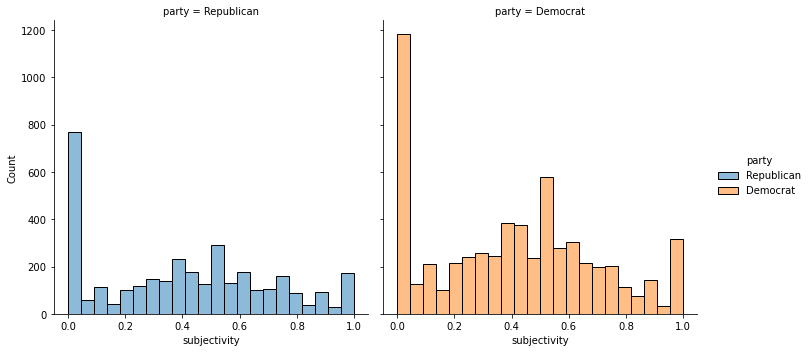

In [54]:
sns.displot(congress_tweets, x="subjectivity", hue = "party", col = "party")
plt.show()

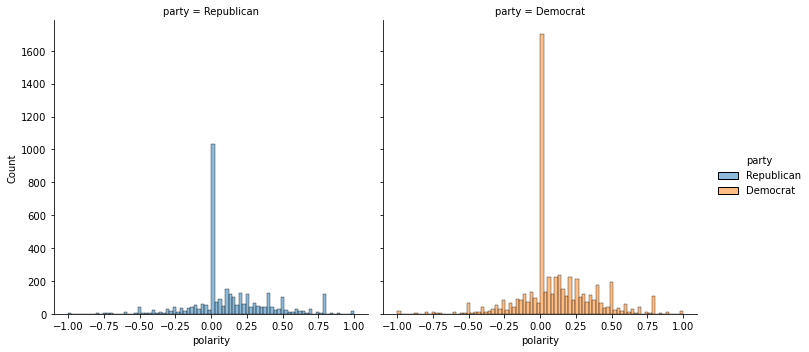

In [55]:
sns.displot(congress_tweets, x="polarity", hue = "party", col = "party")
plt.show()

## MJK/NE - INTERPRET

## 3-2) compare Senators v. Representatives 

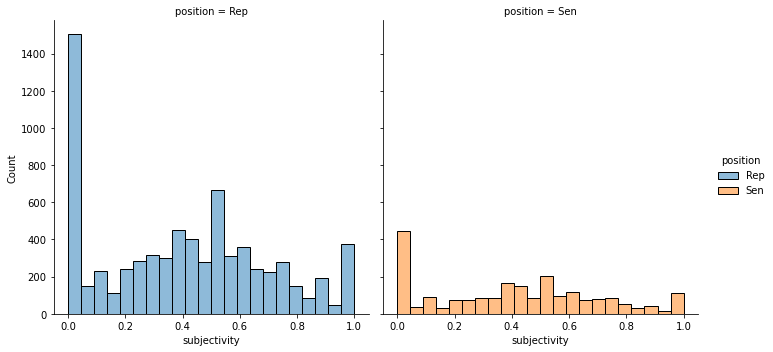

In [56]:
sns.displot(congress_tweets, x="subjectivity", hue = 'position', col = 'position')
plt.show()

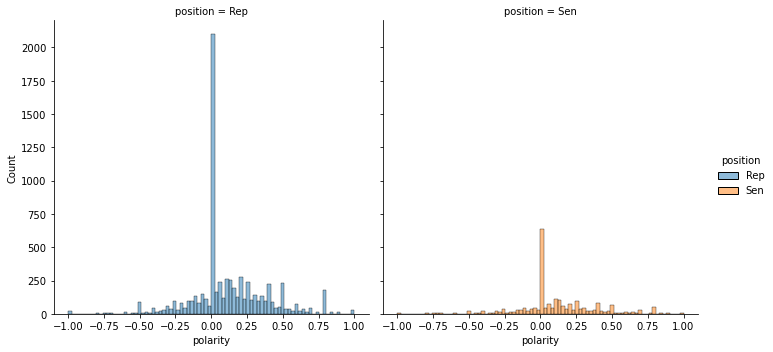

In [57]:
sns.displot(congress_tweets, x="polarity", hue = 'position', col = 'position')
plt.show()

## MJK/NE - INTERPRET

## Representatives tend to post more factual information(subjectivity ==0) than Senators

## Featurization

Before going to classification, explore different featurization techniques. Create three dataframes or arrays to represent your text features, specifically:

* Features engineered from your previous analysis. For example, word counts, sentiment scores, topic model etc.
* A term frequency-inverse document frequency matrix. 
* An embedding-based featurization (like a document averaged word2vec)

In the next section, you will experiment with each of these featurization techniques to see which one produces the best classifications.

In [58]:
congress_tweets.columns

Index(['tweet_id', 'screen_name', 'datetime', 'text', 'name_wikipedia',
       'position', 'joined_congress_date', 'birthday', 'gender', 'state',
       'district_number', 'party', 'trump_2016_state_share',
       'clinton_2016_state_share', 'obama_2012_state_share',
       'romney_2012_state_share', 'tokens', 'length_tokens', 'tokens_str',
       'tweets_R', 'tweets_D', 'tweets_Sen', 'tweets_HRep', 'subjectivity',
       'polarity'],
      dtype='object')

### Engineered Text Features

In [59]:
# Engineered Features
engineered_features = congress_tweets[['polarity', 'subjectivity']].reset_index(drop = True)

# Topic Model + Engineered Features
engineered_features_with_topics = topic_dist_df.join(engineered_features.reset_index(drop = True))

#EG: the last topic_dist_df that was generated was for House of Rep (remember the list of five new_var),
# so this is the one that is being appended here. I don't think that's what we want. So my question is,
# which one do we want? All? or do we need to create a new df for each group: party (2) and position (2)?

In [60]:
engineered_features_with_topics.head() # check first few rows of df with engineered text feats

,0,1,2,3,4,polarity,subjectivity
0,0.042916,0.042954,0.672886,0.198126,0.043118,0.000000,0.0
1,0.050906,0.050905,0.050927,0.796320,0.050942,0.000000,0.0
2,0.760192,0.059213,0.059522,0.060950,0.060123,0.800000,1.0
3,0.045958,0.045964,0.046040,0.627217,0.234821,0.000000,0.0
4,0.036484,0.036413,0.036395,0.854313,0.036395,-0.166667,1.0


### Bag-of-words or Tf-idf

In [61]:
# Frequency Based featurization
X = congress_tweets['tokens_str']
tf = TfidfVectorizer()

tfidf_matrix =  tf.fit_transform(X)
dense_matrix = tfidf_matrix.todense()
tfidf_df = pd.DataFrame(tfidf_matrix.todense(), columns = tf.get_feature_names())

/Users/ernesto/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [62]:
tfidf_df.head()

,03,08232020,082419,0amazon,0coors,0gm,0we,10,100,1000,...,zuckbuck,zuckerberg,zulfikar,zurfluh,ángeles,áreas,ōlelo,תודה,مبارک,نوروز
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
X.head(30)

0     oh14 salutes patrolman st clair fox8news 5year...
1     case missed bipartisanship works bill eradicat...
2      wishing happy passover celebrating seder tonight
3     whitehouse president realdonaldtrump signed bi...
4     sent letter demanding administration stop play...
5     president attacks rep ilhan dishonest dangerou...
6     housegop time holding china accountable china ...
7     wdtnews confirmed covid19 cases jefferson coun...
8     svleadershipgrp game changers accept responsib...
9     nation remain land free long home brave ” elme...
10    true address soon thehill charitable giving am...
11    preach shondarhimes homeschooling 6year old 8y...
12    public institutions asu nation student fulbrig...
13    way eric swalwell continue serve house intelli...
14    air sethleibsohn talk todays developments impe...
15    whistleblower reportedly worked joe biden ukra...
16    montclairnjgov essex county satellite testing ...
17    know lot concern food supply chain bay are

### Word Embedding - N STOPPED HERE 

In [64]:
#Using the function to re-tokenize
# congress_tweets['tokens']= congress_tweets['text'].map(lambda x: rem_punc_stop(x))
#EG: do we want to delete the line above since we don't use it anymore?

#Create word embedding model
model = gensim.models.Word2Vec(congress_tweets['tokens'], vector_size=100, window=3, \
                               min_count=5, sg=0, alpha=0.025, batch_words=10000)

In [65]:
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,...,romney_2012_state_share,tokens,length_tokens,tokens_str,tweets_R,tweets_D,tweets_Sen,tweets_HRep,subjectivity,polarity
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,...,"2,661,437","[oh14, salutes, patrolman, st, clair, fox8news...",14,oh14 salutes patrolman st clair fox8news 5year...,oh14 salutes patrolman st clair fox8news 5year...,,,oh14 salutes patrolman st clair fox8news 5year...,0.0,0.000000
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,...,"4,839,958","[case, missed, bipartisanship, works, bill, er...",9,case missed bipartisanship works bill eradicat...,,case missed bipartisanship works bill eradicat...,,case missed bipartisanship works bill eradicat...,0.0,0.000000
2,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,...,"971,869","[wishing, happy, passover, celebrating, seder,...",6,wishing happy passover celebrating seder tonight,,wishing happy passover celebrating seder tonight,,wishing happy passover celebrating seder tonight,1.0,0.800000
3,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,...,"4,569,843","[whitehouse, president, realdonaldtrump, signe...",12,whitehouse president realdonaldtrump signed bi...,whitehouse president realdonaldtrump signed bi...,,,whitehouse president realdonaldtrump signed bi...,0.0,0.000000
4,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,...,"2,490,431","[sent, letter, demanding, administration, stop...",22,sent letter demanding administration stop play...,,sent letter demanding administration stop play...,,sent letter demanding administration stop play...,1.0,-0.166667


In [66]:
len(congress_tweets['tokens'][0])

14

In [67]:
doc = [word for word in congress_tweets['tokens'][0] if word in model.wv.index_to_key]
len(doc)

6

In [68]:
doc [0:5]

['st', 'battling', 'cancer', 'police', 'officer']

In [69]:
#Now let's grab the first vector for each token and take their mean:
first_vec = []
for token in model.wv.__getitem__(doc):
    first_vec.append(token[0])
np.mean(first_vec)

-0.12741408

In [70]:
#create this for every word - get all the means (FROM LAB)
#Function to average word embeddings for a document; use examples from lab to apply this function. You can use also other techniques such as PCA and doc2vec instead.
#get an average embedding for each document 
def document_vector(word2vec_model, doc):
    doc = [word for word in doc if word in model.wv.index_to_key]
    return np.mean(word2vec_model.wv.__getitem__(doc), axis=0)

In [71]:
# Initialize an array for the size of the corpus
#each word is represented by 100 element list, so then it averages the first element for each word across all the words
empty_list_embeddings_means = []
index_num = 0 # identify docs we can't get vector for
empty_docs = []
for doc in congress_tweets['tokens']: # append the vector for each document
    doc = [word for word in doc if word in model.wv.index_to_key]
    if len(doc)<1:
        empty_docs.append(index_num) # collect index for docs we can't get vector for -- used later in classification
        continue
    empty_list_embeddings_means.append(document_vector(model, doc))
    index_num += 1
doc_average_embeddings = np.array(empty_list_embeddings_means) # list to array

In [72]:
doc_average_embeddings

array([[-0.12741408,  0.2910228 ,  0.10756082, ..., -0.27747098,
         0.15399724, -0.01019722],
       [-0.0814597 ,  0.2573638 ,  0.09777868, ..., -0.24336573,
         0.13390553,  0.00910098],
       [-0.11098083,  0.28141072,  0.10569098, ..., -0.26959231,
         0.15872937, -0.00254854],
       ...,
       [-0.10993912,  0.25020304,  0.09741117, ..., -0.2391681 ,
         0.13177821, -0.01074714],
       [-0.16029696,  0.3729627 ,  0.1259488 , ..., -0.34681916,
         0.19153994, -0.01093997],
       [-0.14533025,  0.36037886,  0.1305463 , ..., -0.34432057,
         0.19268821, -0.02032342]], dtype=float32)

In [73]:
#AVE EMBEDDINGS FOR EACH DOC 
doc_average_embeddings.shape

(9398, 100)

In [74]:
#create dataframe
word2vec_features_df = pd.DataFrame(doc_average_embeddings) 
word2vec_features_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.127414,0.291023,0.107561,-0.052435,0.102350,-0.382238,0.071052,0.549517,-0.163938,-0.124185,...,0.349187,0.068492,0.055006,0.020782,0.349511,0.230466,0.111961,-0.277471,0.153997,-0.010197
1,-0.081460,0.257364,0.097779,-0.046257,0.076261,-0.348753,0.045533,0.479956,-0.160403,-0.112446,...,0.298677,0.074377,0.034115,0.005786,0.279497,0.196264,0.080323,-0.243366,0.133906,0.009101
2,-0.110981,0.281411,0.105691,-0.048041,0.095812,-0.364114,0.066707,0.547477,-0.156708,-0.120484,...,0.347907,0.061047,0.060653,0.022569,0.346604,0.244926,0.102243,-0.269592,0.158729,-0.002549
3,-0.160155,0.413051,0.158518,-0.064375,0.117828,-0.534715,0.087277,0.759295,-0.240155,-0.184164,...,0.456700,0.098984,0.057299,0.014450,0.460387,0.304809,0.139073,-0.393385,0.223798,0.004176
4,-0.136939,0.307716,0.107429,-0.047704,0.104081,-0.375739,0.076031,0.561619,-0.169270,-0.124789,...,0.362286,0.077540,0.051316,0.022942,0.356284,0.235071,0.126384,-0.288193,0.151468,-0.014165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9393,-0.143735,0.340254,0.121975,-0.060070,0.112626,-0.433150,0.082083,0.638281,-0.195838,-0.141431,...,0.410357,0.081054,0.062991,0.030541,0.402608,0.272066,0.133399,-0.322931,0.173918,-0.012091
9394,-0.165078,0.344445,0.116435,-0.053511,0.118028,-0.405988,0.087085,0.618393,-0.182381,-0.138242,...,0.414761,0.091386,0.055376,0.033022,0.398709,0.263792,0.148263,-0.315747,0.161497,-0.022707
9395,-0.109939,0.250203,0.097411,-0.045102,0.082328,-0.323002,0.059453,0.461329,-0.139919,-0.108319,...,0.291764,0.066728,0.041012,0.007318,0.299518,0.197091,0.095589,-0.239168,0.131778,-0.010747
9396,-0.160297,0.372963,0.125949,-0.065936,0.126150,-0.479691,0.085052,0.703070,-0.207157,-0.151953,...,0.455667,0.101145,0.073520,0.044654,0.442417,0.304732,0.150938,-0.346819,0.191540,-0.010940


## Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc. 
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics. 

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

### Train Six Models with Just Text

In [75]:
# collect the labels for party and chamber membership

lb_style = LabelBinarizer()
y_party = congress_tweets['party'] = lb_style.fit_transform(congress_tweets['party'])
    #0=Republican and 1=Democrat
y_chamber = congress_tweets['position'] =lb_style.fit_transform(congress_tweets['position'])
    #0=House of Rep and 1=Senate

In [76]:
# sanity check
y_party

array([[1],
       [0],
       [0],
       ...,
       [1],
       [0],
       [1]])

### 1. Engineered features

#### 1.1 classify party

In [77]:
X_ef_p_train, X_ef_p_test, y_p_train, y_p_test = train_test_split(engineered_features_with_topics,
                                                                  y_party,
                                                                  stratify=y_party,
                                                                  train_size = 0.80,
                                                                  test_size= 0.20,
                                                                  random_state = 10)

In [78]:
# sanity check
print(X_ef_p_train.shape)
print(y_p_train.shape)
print(X_ef_p_test.shape)
print(y_p_test.shape)

(7545, 7)
(7545, 1)
(1887, 7)
(1887, 1)


In [79]:
# create a model
logit_reg = LogisticRegression()

# fit the model
logit_model = logit_reg.fit(X_ef_p_train, y_p_train.ravel())

# create pedictions
y_p_pred = logit_model.predict(X_ef_p_test)

# create confusion matrix
cf_matrix_p = confusion_matrix(y_p_test, y_p_pred, normalize = "true")

/Users/ernesto/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/ernesto/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


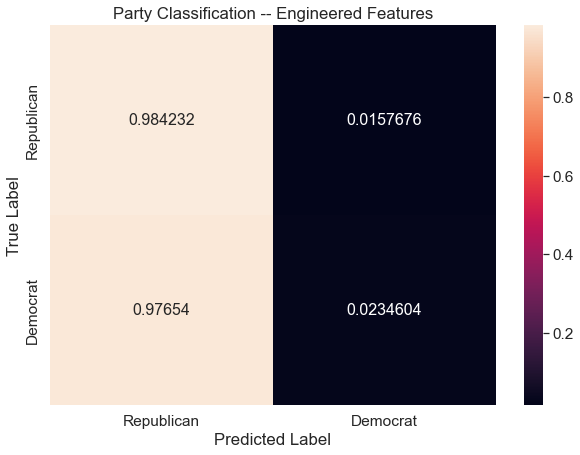

In [80]:
# display confusion matrix

df_cm = pd.DataFrame(cf_matrix_p, range(2),
                      range(2))

df_cm = df_cm.rename(index=str, columns={0: "Republican", 1: "Democrat"})
df_cm.index = ["Republican", "Democrat"]

plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title("Party Classification -- Engineered Features")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [81]:
#EG: The model is not giving us great pedictions. I think it has to do with the fact that we used the topics
# for only the House of Rep in the engineered_features_with_topics. We'll have to fix that to test the model again.

#### 1.2 classify chamber

In [82]:
X_ef_c_train, X_ef_c_test, y_c_train, y_c_test = train_test_split(engineered_features_with_topics,
                                                                  y_chamber,
                                                                  stratify=y_chamber,
                                                                  train_size = 0.80,
                                                                  test_size=0.20,
                                                                  random_state = 10)

In [83]:
# sanity check
print(X_ef_c_train.shape)
print(y_c_train.shape)
print(X_ef_c_test.shape)
print(y_c_test.shape)

(7545, 7)
(7545, 1)
(1887, 7)
(1887, 1)


In [84]:
# create a model
logit_reg = LogisticRegression()

# fit the model
logit_model = logit_reg.fit(X_ef_c_train, y_c_train.ravel())

# create pedictions
y_c_pred = logit_model.predict(X_ef_c_test)

# create confusion matrix
cf_matrix_c = confusion_matrix(y_c_test, y_c_pred, normalize = "true")

/Users/ernesto/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/ernesto/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


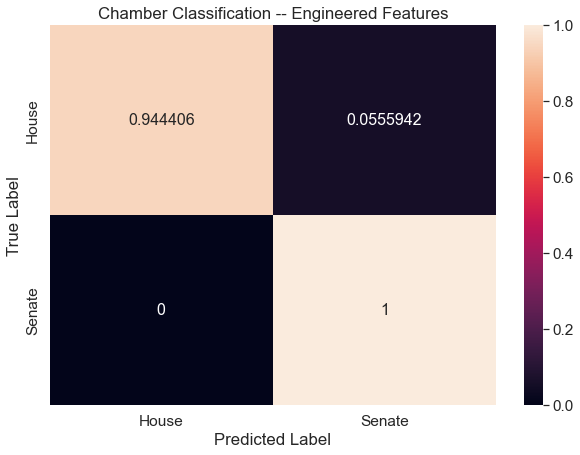

In [85]:
# display confusion matrix

df_cm = pd.DataFrame(cf_matrix_c, range(2),
                      range(2))

df_cm = df_cm.rename(index=str, columns={0: "House", 1: "Senate"})
df_cm.index = ["House", "Senate"]

plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title("Chamber Classification -- Engineered Features")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [86]:
#EG: this Logistic model works great, but this is only because the df only contains topics related to House of Rep.
# so the data was biased since the beginning.

### 2. tf-idf

#### 2.1 classify party

In [87]:
X_tfidf_p_train, X_tfidf_p_test, y_p_train, y_p_test = train_test_split(tfidf_df,
                                                                        y_party,
                                                                        stratify=y_party,
                                                                        train_size = 0.80,
                                                                        test_size=0.20,
                                                                        random_state = 10)

In [88]:
# sanity check
print(X_tfidf_p_train.shape)
print(y_p_train.shape)
print(X_tfidf_p_test.shape)
print(y_p_test.shape)

(7545, 27673)
(7545, 1)
(1887, 27673)
(1887, 1)


In [89]:
# create a model
logit_reg = LogisticRegression()

# fit the model
logit_model = logit_reg.fit(X_tfidf_p_train, y_p_train.ravel())

# create pedictions
y_p_pred = logit_model.predict(X_tfidf_p_test)

# create confusion matrix
cf_matrix_p = confusion_matrix(y_p_test, y_p_pred, normalize = "true")

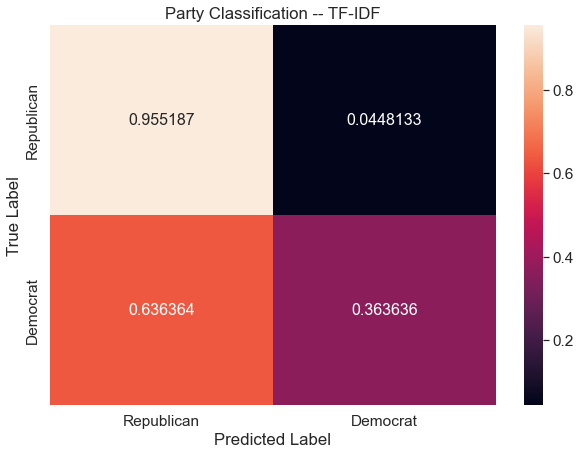

In [90]:
# display confusion matrix

# cf_matrix = cf_matrix.rename(index=str, columns={0: "Republican", 1: "Democrat"})
# df_cm.index = ["Republican", "Democrat"]

df_cm = pd.DataFrame(cf_matrix_p, range(2),
                      range(2))

df_cm = df_cm.rename(index=str, columns={0: "Republican", 1: "Democrat"})
df_cm.index = ["Republican", "Democrat"]

plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title("Party Classification -- TF-IDF")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### 2.2 classify chamber

In [91]:
X_tfidf_c_train, X_tfidf_c_test, y_c_train, y_c_test = train_test_split(tfidf_df,
                                                                        y_chamber,
                                                                        stratify=y_chamber,
                                                                        train_size = 0.80,
                                                                        test_size=0.20,
                                                                        random_state = 10)

In [92]:
# sanity check
print(X_tfidf_c_train.shape)
print(y_c_train.shape)
print(X_tfidf_c_test.shape)
print(y_c_test.shape)

(7545, 27673)
(7545, 1)
(1887, 27673)
(1887, 1)


In [93]:
# create a model
logit_reg = LogisticRegression()

# fit the model
logit_model = logit_reg.fit(X_tfidf_c_train, y_c_train.ravel())

# create pedictions
y_c_pred = logit_model.predict(X_tfidf_c_test)

# create confusion matrix
cf_matrix_c = confusion_matrix(y_c_test, y_c_pred, normalize = "true")

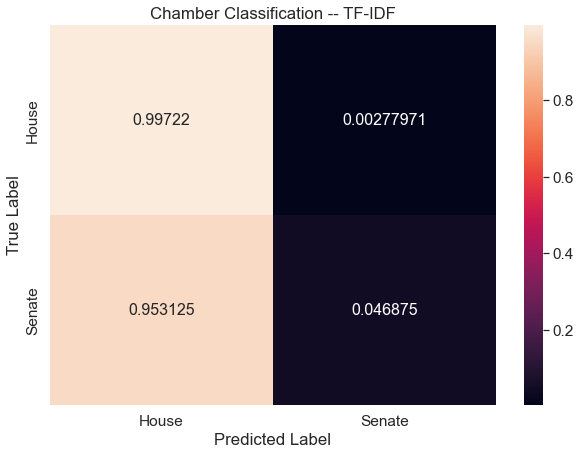

In [94]:
# display confusion matrix

# cf_matrix = cf_matrix.rename(index=str, columns={0: "Republican", 1: "Democrat"})
# df_cm.index = ["Republican", "Democrat"]

df_cm = pd.DataFrame(cf_matrix_c, range(2),
                      range(2))

df_cm = df_cm.rename(index=str, columns={0: "House", 1: "Senate"})
df_cm.index = ["House", "Senate"]

plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title("Chamber Classification -- TF-IDF")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [95]:
#EG: in general, tf-idf is better for Hourse of Rep than senate. 
# I'm not sure why. Ideas?

### 3. Embeddings

In [96]:
# adjust length of labels y (for party and chamber) to match embedding length

#party
emb_y_party = y_party
emb_y_party = np.delete(emb_y_party, empty_docs, axis=0)

#chamber
emb_y_chamber = y_chamber
emb_y_chamber = np.delete(emb_y_chamber, empty_docs, axis=0)

#### 3.1 classify party

In [97]:
X_emb_p_train, X_emb_p_test, y_p_train, y_p_test = train_test_split(doc_average_embeddings,
                                                                    emb_y_party,
                                                                    stratify=emb_y_party,
                                                                    train_size = 0.80,
                                                                    test_size=0.20,
                                                                    random_state = 10)

In [98]:
# sanity check
print(X_emb_p_train.shape)
print(y_p_train.shape)
print(X_emb_p_test.shape)
print(y_p_test.shape)

(7518, 100)
(7518, 1)
(1880, 100)
(1880, 1)


In [99]:
# create a model
logit_reg = LogisticRegression()

# fit the model
logit_model = logit_reg.fit(X_emb_p_train, y_p_train.ravel())

# create pedictions
y_p_pred = logit_model.predict(X_emb_p_test)

# create confusion matrix
cf_matrix_p = confusion_matrix(y_p_test, y_p_pred, normalize = "true")

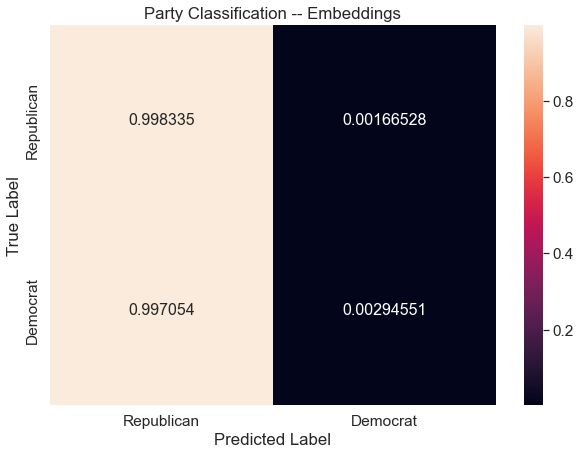

In [100]:
# display confusion matrix

# cf_matrix = cf_matrix.rename(index=str, columns={0: "Republican", 1: "Democrat"})
# df_cm.index = ["Republican", "Democrat"]

df_cm = pd.DataFrame(cf_matrix_p, range(2),
                      range(2))

df_cm = df_cm.rename(index=str, columns={0: "Republican", 1: "Democrat"})
df_cm.index = ["Republican", "Democrat"]

plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title("Party Classification -- Embeddings")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### 3.2 classify chamber

In [101]:
X_emb_c_train, X_emb_c_test, y_c_train, y_c_test = train_test_split(doc_average_embeddings,
                                                                    emb_y_chamber,
                                                                    stratify=emb_y_chamber,
                                                                    train_size = 0.80,
                                                                    test_size=0.20,
                                                                    random_state = 10)

In [102]:
# sanity check
print(X_emb_c_train.shape)
print(y_c_train.shape)
print(X_emb_c_test.shape)
print(y_c_test.shape)

(7518, 100)
(7518, 1)
(1880, 100)
(1880, 1)


In [103]:
# create a model
logit_reg = LogisticRegression()

# fit the model
logit_model = logit_reg.fit(X_emb_c_train, y_c_train.ravel())

# create pedictions
y_c_pred = logit_model.predict(X_emb_c_test)

# create confusion matrix
cf_matrix_c = confusion_matrix(y_c_test, y_c_pred, normalize = "true")

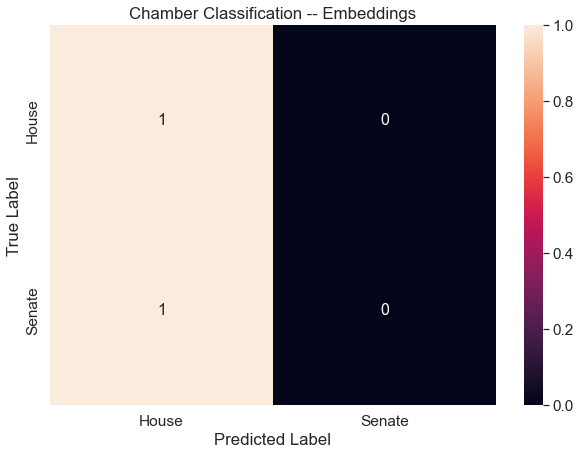

In [104]:
# display confusion matrix

# cf_matrix = cf_matrix.rename(index=str, columns={0: "Republican", 1: "Democrat"})
# df_cm.index = ["Republican", "Democrat"]

df_cm = pd.DataFrame(cf_matrix_c, range(2),
                      range(2))

df_cm = df_cm.rename(index=str, columns={0: "House", 1: "Senate"})
df_cm.index = ["House", "Senate"]

plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title("Chamber Classification -- Embeddings")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [105]:
#EG: I don't understand why the embedding model is giving us such bad predictions for party and chamber.
# Any thoughts? Maybe you two can see something I can't.

### Two Combined Models

In [ ]:
# two models ([best text features + non-text features] * [democrat/republican, senator/representative])
...

## Discussion Questions

1. Why do standard preprocessing techniques need to be further customized to a particular corpus?

**Your Answer Here**

2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?

**Your Answer Here**

3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?

**Your Answer Here**

4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?

**Your Answer Here**